## **Introduction**
#### This notebook modifies the existing highest scoring notebook(Enefit - Best LB shared with early stop,from R. Reggiani, v21) by making some small changes on model. The most important change is that it enables the use of GPU. There is some small CV improvement, but the biggest improvement is on runtime which decreases from 5k+ seconds to around 1.5k seconds. 

I keep all the comments from the previous notebook. Enjoy!



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, timedelta
import enefit
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


## **Highlighted Definitions**
#### <u>**Prosumers**</u> Means in our case the person that consume energy and produce it 

#### 🤔 How Solar Energy, Gas and Electricity are related? 
Answer will be in the EDA Notebook that will contain many useful insights that i'm sure will help you improve your competition score, So if you find this notebook helpful please upvote and follow and let's go to the code.   

## **Imports**

In [2]:
train= pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/train.csv')
gas_df= pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv')
electricity_df= pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv')
client_df= pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/client.csv')
fw_df= pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv')
hw_df= pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv')
locations= pd.read_csv('/kaggle/input/d/ahmedabdulwahab/locations/county_lon_lats.csv')

## **Train function**

In [3]:
def preTrain(data, client, hist_weather,
               forecast_weather, electricity, gas, locations):
    
    #Dropping (target) nan values
    data= data[data['target'].notnull()] 
    #Converting (datetime) column to datetime
    data['datetime'] = pd.to_datetime(data['datetime'], utc=True)
    #Renaming (forecast_date) to (datetime) for merging with the train data later
    electricity = electricity.rename(columns= {'forecast_date' : 'datetime'})
    #Converting (datetime) column to datetime
    electricity['datetime'] = pd.to_datetime(electricity['datetime'], utc= True)
    #Decreasing (data_block_id) in client data because it's 2 steps ahead from train's data (data_block_id)
    client['data_block_id'] -= 2
      
    """locations is a custom data that will help replace (latitude) and (longitude)
    columns by the counties for each coordination | you can find the data in Input """
    locations = locations.drop('Unnamed: 0', axis= 1) 
        
    #Rounding the (latitude) and (longitude) for 1 decimal fraction
    forecast_weather[['latitude', 'longitude']] = forecast_weather[['latitude',
                                                                    'longitude']].astype(float).round(1)
    #Merging counties in locations data with the coordinations in the forecast_weather data
    forecast_weather= forecast_weather.merge(locations, how='left',
                                             on=['longitude','latitude'])
    #dropping nan values
    forecast_weather.dropna(axis= 0, inplace= True)    
    #Converting (county) column to integer
    forecast_weather['county'] = forecast_weather['county'].astype('int64')
    #Dropping the columns we won't need | We will use the (forecast_datetime) column instead of the (origin_datetime)
    forecast_weather.drop(['origin_datetime', 'latitude',
                           'longitude', 'hours_ahead', 'data_block_id'], axis=1, inplace= True)
    #Renaming (forecast_datetime) to (datetime) for merging with the train data later
    forecast_weather.rename(columns={'forecast_datetime': 'datetime'}, inplace= True)
    #Converting (datetime) column to datetime
    forecast_weather['datetime']= pd.to_datetime(forecast_weather['datetime'], utc= True)
    """Grouping all forecast_weather columns mean values by hour, So each hour
    will have the mean values of the forecast_weather columns""" 
    forecast_weather_datetime= forecast_weather.groupby([forecast_weather['datetime'].
                                            dt.to_period('h')])[list(forecast_weather.drop(['county',
                                                                                            'datetime'], axis= 1)
                                                                     .columns)].mean().reset_index()
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    forecast_weather_datetime['datetime']= pd.to_datetime(
        forecast_weather_datetime['datetime'].dt.to_timestamp(), utc=True)
    
    """Grouping all forecast_weather columns mean values by hour and county, So each hour and county
    will have the mean values of the forecast_weather columns for each county""" 
    forecast_weather_datetime_county= forecast_weather.groupby(['county',forecast_weather['datetime'].
                              dt.to_period('h')])[list(forecast_weather.drop(['county',
                                                                              'datetime'], axis= 1)
                                                       .columns)].mean().reset_index()
    
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    forecast_weather_datetime_county['datetime']= pd.to_datetime(
        forecast_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)

    #Rounding the (latitude) and (longitude) for 1 decimal fraction           
    hist_weather[['latitude', 'longitude']] = hist_weather[['latitude', 'longitude']].astype(float).round(1)

    #Merging counties in locations data with the coordinations in the historical_weather data
    hist_weather= hist_weather.merge(locations, how='left', on=['longitude','latitude'])    
    #Dropping nan values
    hist_weather.dropna(axis= 0, inplace= True)
    #Dropping the columns we won't need
    hist_weather.drop(['latitude', 'longitude'], axis=1, inplace= True)
    #Converting (county) to integer
    hist_weather['county'] = hist_weather['county'].astype('int64')
    #Converting (datetime) column to datetime
    hist_weather['datetime']= pd.to_datetime(hist_weather['datetime'], utc= True)
    
    """Grouping all historical_weather columns mean values by hour, So each hour
    will have the mean values of the historical_weather columns"""     
    hist_weather_datetime= hist_weather.groupby([hist_weather['datetime'].
                                            dt.to_period('h')])[list(hist_weather.drop(['county',
                                                                                            'datetime',
                                                                                        'data_block_id'], axis= 1)
                                                                     .columns)].mean().reset_index()    
    
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    hist_weather_datetime['datetime']= pd.to_datetime(
        hist_weather_datetime['datetime'].dt.to_timestamp(), utc=True)
    
    #Merging (data_block_id) back after dropping it in the last step | (data_block_id will be used to merge with train data)
    hist_weather_datetime= hist_weather_datetime.merge(
        hist_weather[['datetime', 'data_block_id']], how='left', on='datetime')
    
    """Grouping all historical_weather columns mean values by hour and county, So each hour
    will have the mean values of the historical_weather columns for each county"""   
    hist_weather_datetime_county= hist_weather.groupby(['county',hist_weather['datetime'].
                              dt.to_period('h')])[list(hist_weather.drop(['county',
                                                                              'datetime', 'data_block_id'], axis= 1)
                                                       .columns)].mean().reset_index() 
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    hist_weather_datetime_county['datetime']= pd.to_datetime(
        hist_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)
    #Merging (data_block_id) back after dropping it in the last step
    hist_weather_datetime_county= hist_weather_datetime_county.merge(
        hist_weather[['datetime', 'data_block_id']], how='left', on='datetime')
    #Adding year column in train data
    data['year'] = data['datetime'].dt.year
    #Adding month column in train data
    data['month'] = data['datetime'].dt.month
    #Adding day column in train data
    data['day'] = data['datetime'].dt.day
    #Adding hour column in train data
    data['hour'] = data['datetime'].dt.hour
    #Adding dayofweek column in train data
    data['dayofweek'] = data['datetime'].dt.dayofweek
    #Adding dayofyear column in train data
    data['dayofyear']= data['datetime'].dt.dayofyear
    #Adding hour column to electricity used to merge with the train data
    electricity['hour'] = electricity['datetime'].dt.hour
    #Merging train data with client data
    data= data.merge(client.drop(columns = ['date']), how='left', on=['data_block_id', 'county', 'is_business', 'product_type'])
    
    #Merging train data with gas data
    data= data.merge(gas[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']], how='left', on='data_block_id')
    
    #Merging train data with electricity data    
    data= data.merge(electricity[['euros_per_mwh', 'hour', 'data_block_id']], how='left', on=['hour', 'data_block_id'])
    
    #Merging train data with forecast_weather_datetime data    
    data= data.merge(forecast_weather_datetime, how='left', on=['datetime'])
    
    #Merging train data with forecast_weather_datetime_county data    
    data= data.merge(forecast_weather_datetime_county, how='left', on=['datetime', 'county'],
                     suffixes= ('_fcast_mean','_fcast_mean_by_county'))
    
    #Creating hour columns in both historical_weather data | used to merge both data with the train data
    hist_weather_datetime['hour']= hist_weather_datetime['datetime'].dt.hour
    hist_weather_datetime_county['hour']= hist_weather_datetime_county['datetime'].dt.hour

    #Dropping duplicates and (datetime) column
    hist_weather_datetime.drop_duplicates(inplace=True)
    hist_weather_datetime_county.drop_duplicates(inplace=True)
    hist_weather_datetime.drop('datetime', axis= 1, inplace= True)
    hist_weather_datetime_county.drop('datetime', axis= 1, inplace= True)

    #Merging hist_weather_datetime with train data
    data= data.merge(hist_weather_datetime, how='left', on=['data_block_id', 'hour'])


    #Merging hist_weather_datetime_county with train data
    data= data.merge(hist_weather_datetime_county, how='left', on=['data_block_id', 'county', 'hour'],
                     suffixes= ('_hist_mean','_hist_mean_by_county'))

    #Filling nan values with hourly mean values for each column | Helps for the county missing value 
    data= data.groupby(['year', 'day', 'hour'], as_index=False).apply(lambda x: x.ffill().bfill()).reset_index()
    
    #Dropping uneeded data
    data.drop(['level_0', 'level_1', 'row_id', 'data_block_id', 'year'], axis= 1, inplace= True)
    return data

In [4]:
def create_revealed_targets_train(data, N_day_lags):
    '''Creating lagged target values | A target value depends on what was a target value n days ago'''
    
    original_datetime = data['datetime']
    revealed_targets = data[['datetime', 'prediction_unit_id', 'is_consumption', 'target']].copy()
    
    #Create revealed targets for n days lags
    for day_lag in range(2, N_day_lags+1):
        revealed_targets['datetime'] = original_datetime + pd.DateOffset(day_lag)
        data = data.merge(revealed_targets, 
                          how='left', 
                          on = ['datetime', 'prediction_unit_id', 'is_consumption'],
                          suffixes = ('', f'_{day_lag}_days_ago')
                         )
    return data

In [5]:
#Applying the Train function and storing our train data in the (train) variable
train= preTrain(train, client_df, hw_df, fw_df, electricity_df, gas_df, locations)
#Specify how many days to lag and applying the function
N_day_lags = 7
train = create_revealed_targets_train(train, N_day_lags = N_day_lags)
train['datetime'] = train['datetime'].astype('int64')

## Data transformation

In [6]:
#Data transformation
train['sin_hour']= (np.pi * np.sin(train['hour']) / 12)
train['cos_hour']= (np.pi * np.cos(train['hour']) / 12)
train['sin_dayofyear']= (np.pi * np.sin(train['dayofyear']) / 183)
train['cos_dayofyear']= (np.pi * np.cos(train['dayofyear']) / 183)
train['target_mean']= train[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].mean(1)
train['target_std']= train[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].std(1)
train['target_var']= train[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].var(1)

In [7]:
#Log columns with outliers
to_log= ['installed_capacity', 'euros_per_mwh', 'temperature_fcast_mean', 'dewpoint_fcast_mean',
        'cloudcover_high_fcast_mean', 'cloudcover_low_fcast_mean', 'cloudcover_mid_fcast_mean', 'cloudcover_total_fcast_mean',
        '10_metre_u_wind_component_fcast_mean', '10_metre_v_wind_component_fcast_mean', 'direct_solar_radiation_fcast_mean',
        'snowfall_fcast_mean', 'total_precipitation_fcast_mean', 'temperature_fcast_mean_by_county', 'dewpoint_fcast_mean_by_county',
        'cloudcover_high_fcast_mean_by_county', 'cloudcover_low_fcast_mean_by_county', 'cloudcover_mid_fcast_mean_by_county',
        'cloudcover_total_fcast_mean_by_county', '10_metre_u_wind_component_fcast_mean_by_county', '10_metre_v_wind_component_fcast_mean_by_county',
        'surface_solar_radiation_downwards_fcast_mean_by_county', 'snowfall_fcast_mean_by_county', 'total_precipitation_fcast_mean_by_county',
        'rain_hist_mean', 'snowfall_hist_mean', 'windspeed_10m_hist_mean_by_county', 'target_2_days_ago', 'target_3_days_ago',
        'target_4_days_ago', 'target_5_days_ago', 'target_6_days_ago', 'target_7_days_ago', 'target_mean', 'target_std']
for i in to_log:
    train[f"log_{i}"]= np.where((train[i])!= 0, np.log(train[i]),0)

## Training columns

In [8]:
# Reduce for test
# train = train[::1000]

#Storing training features into numpy arrays
X= train[train['is_consumption'] != 0].drop('target', axis= 1)
y= train[train['is_consumption'] != 0]['target']

#Storing production targets into an array itself | Will seperate it into another model
X2= train[train['is_consumption'] == 0].drop('target', axis= 1)
y2= train[train['is_consumption'] == 0]['target']

## Training models

In [9]:

Xtr, Xvl, Ytr, Yvl = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=51)

#Model 1
best_params = {
    'num_iterations': 4000,
    'verbose': -1,
    'objective': 'tweedie',
    'num_leaves': 455,
    'learning_rate': 0.01,
    'colsample_bytree' : 0.92,
    'colsample_bynode' : 0.45,
    'reg_alpha'        : 3.62,
    'reg_lambda'        : 1.65,
    'min_data_in_leaf': 198,
    'max_depth': 20,
    "n_jobs" : 4,
    "device" : "gpu"
}

lgbm= LGBMRegressor(**best_params, random_state= 73)

In [10]:
lgbm.fit(Xtr, Ytr,
        eval_set=[(Xvl, Yvl)],
        callbacks=[
            lgb.callback.early_stopping(stopping_rounds=100),
            lgb.callback.log_evaluation(period=100),
        ],)

[LightGBM] [Warning] min_data_in_leaf is set=198, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=198
Training until validation scores don't improve for 100 rounds
[100]	valid_0's tweedie: 66.2802
[200]	valid_0's tweedie: 62.3039
[300]	valid_0's tweedie: 61.6379
[400]	valid_0's tweedie: 61.5058
[500]	valid_0's tweedie: 61.4585
[600]	valid_0's tweedie: 61.4281
[700]	valid_0's tweedie: 61.4053
[800]	valid_0's tweedie: 61.3892
[900]	valid_0's tweedie: 61.3779
[1000]	valid_0's tweedie: 61.369
[1100]	valid_0's tweedie: 61.3613
[1200]	valid_0's tweedie: 61.3549
[1300]	valid_0's tweedie: 61.3493
[1400]	valid_0's tweedie: 61.3445
[1500]	valid_0's tweedie: 61.3401
[1600]	valid_0's tweedie: 61.3364
[1700]	valid_0's tweedie: 61.333
[1800]	valid_0's tweedie: 61.3298
[1900]	valid_0's tweedie: 61.3269
[2000]	valid_0's tweedie: 61.3243
[2100]	valid_0's tweedie: 61.322
[2200]	valid_0's tweedie: 61.3198
[2300]	valid_0's tweedie: 61.3179
[2400]	valid_0's tweedie: 61.316
[2500]	vali

LGBMRegressor(colsample_bynode=0.45, colsample_bytree=0.92, device='gpu',
              learning_rate=0.01, max_depth=20, min_data_in_leaf=198, n_jobs=4,
              num_iterations=4000, num_leaves=455, objective='tweedie',
              random_state=73, reg_alpha=3.62, reg_lambda=1.65, verbose=-1)

In [11]:
#Model 2
Xtr, Xvl, Ytr, Yvl = train_test_split(X2, y2, test_size=0.40, shuffle=True,  random_state=51)


best_params = {
        'n_iter'           : 4000,
        'learning_rate': 0.01,
        'max_depth': 13,
        'num_leaves': 455,
        'min_data_in_leaf': 63,
        'min_data_per_groups': 59,
        'verbose'          : -1,
        'objective'        : 'tweedie',
        'colsample_bytree' : 0.89,
        'colsample_bynode' : 0.45,
        'lambda_l1'        : 3.62,
        'lambda_l2'        : 1.65,
        "n_jobs" : 4,
        "device" : "gpu"
}


lgbm2= LGBMRegressor(**best_params, random_state= 73)
lgbm2.fit(Xtr, Ytr,
        eval_set=[(Xvl, Yvl)],
        callbacks=[
            lgb.callback.early_stopping(stopping_rounds=100),
            lgb.callback.log_evaluation(period=100),
        ],)



Training until validation scores don't improve for 100 rounds
[100]	valid_0's tweedie: 23.4002
[200]	valid_0's tweedie: 19.3984
[300]	valid_0's tweedie: 18.3115
[400]	valid_0's tweedie: 17.9868
[500]	valid_0's tweedie: 17.8703
[600]	valid_0's tweedie: 17.8145
[700]	valid_0's tweedie: 17.7836
[800]	valid_0's tweedie: 17.7646
[900]	valid_0's tweedie: 17.7505
[1000]	valid_0's tweedie: 17.7343
[1100]	valid_0's tweedie: 17.7208
[1200]	valid_0's tweedie: 17.7096
[1300]	valid_0's tweedie: 17.7002
[1400]	valid_0's tweedie: 17.6931
[1500]	valid_0's tweedie: 17.6862
[1600]	valid_0's tweedie: 17.6805
[1700]	valid_0's tweedie: 17.6758
[1800]	valid_0's tweedie: 17.6718
[1900]	valid_0's tweedie: 17.6684
[2000]	valid_0's tweedie: 17.6652
[2100]	valid_0's tweedie: 17.6624
[2200]	valid_0's tweedie: 17.6601
[2300]	valid_0's tweedie: 17.6579
[2400]	valid_0's tweedie: 17.6561
[2500]	valid_0's tweedie: 17.6547
[2600]	valid_0's tweedie: 17.6535
[2700]	valid_0's tweedie: 17.6527
[2800]	valid_0's tweedie: 17.

LGBMRegressor(colsample_bynode=0.45, colsample_bytree=0.89, device='gpu',
              lambda_l1=3.62, lambda_l2=1.65, learning_rate=0.01, max_depth=13,
              min_data_in_leaf=63, min_data_per_groups=59, n_iter=4000,
              n_jobs=4, num_leaves=455, objective='tweedie', random_state=73,
              verbose=-1)

## Feature importances

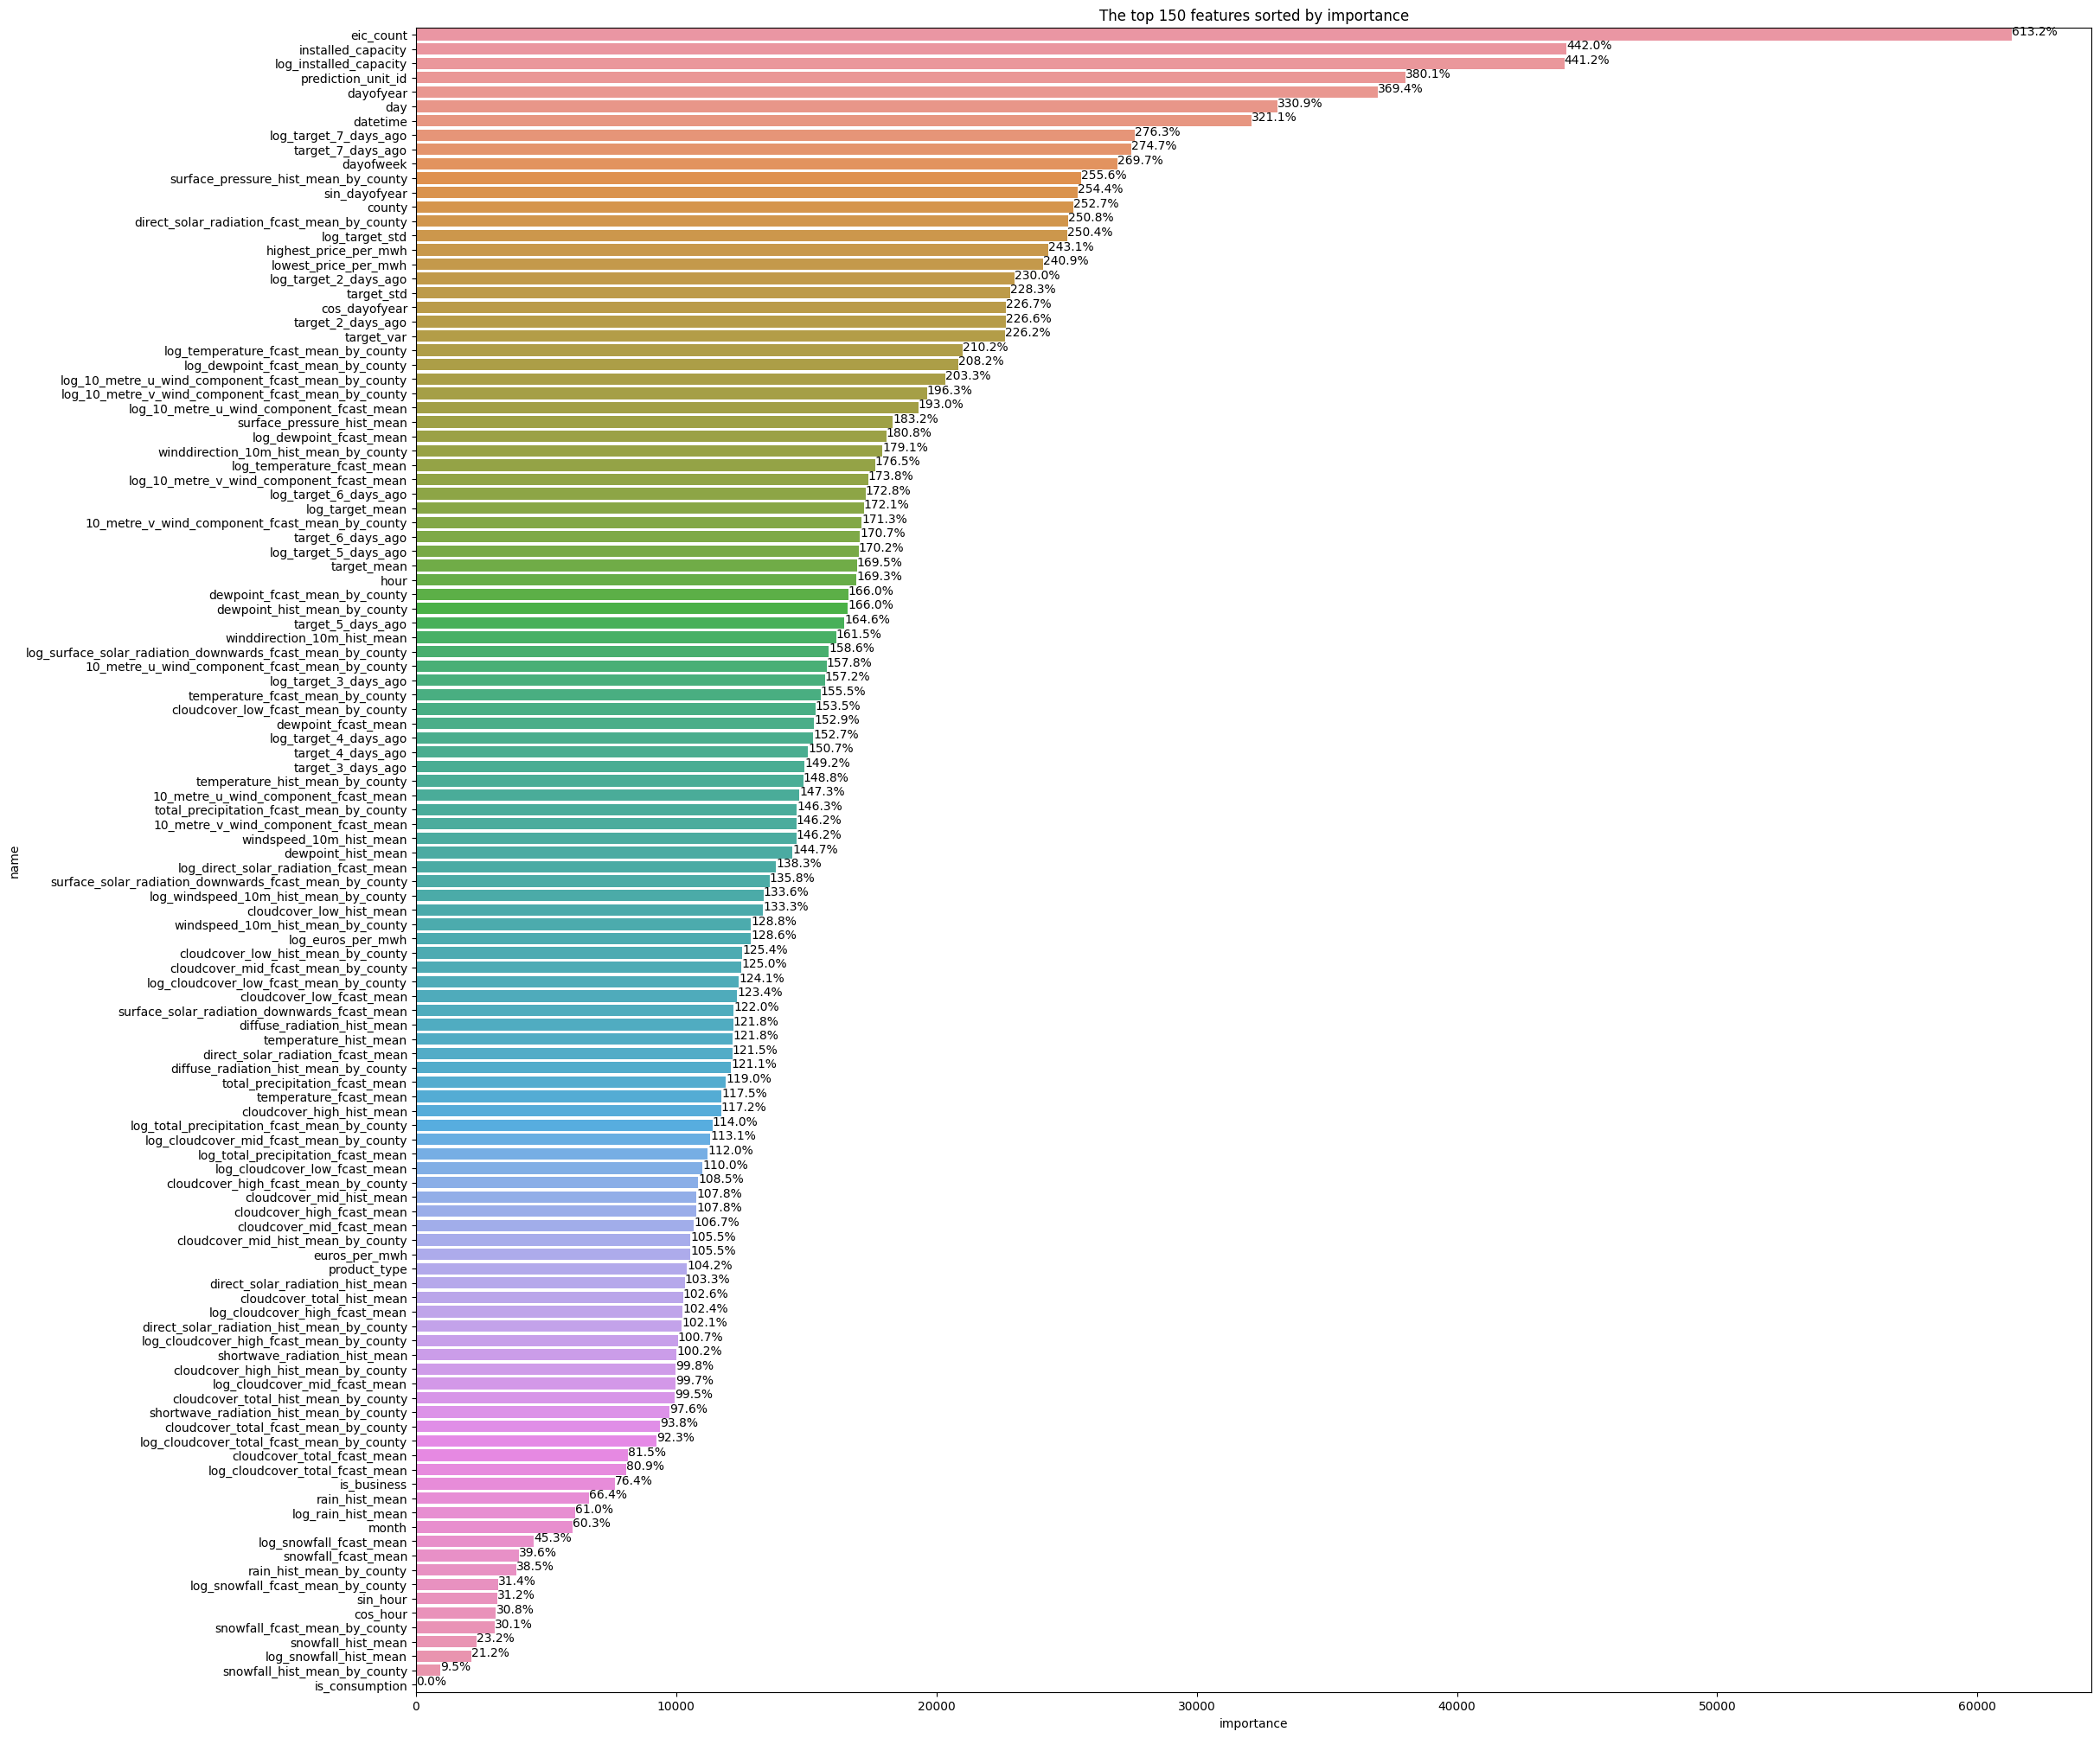

In [12]:
TOP = 150
importance_data = pd.DataFrame({'name': train.drop('target', axis= 1).columns
, 'importance': lgbm.feature_importances_})
importance_data = importance_data.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(25,25))
sns.barplot(data=importance_data[:TOP],
            x = 'importance',
            y = 'name'
        )
patches = ax.patches
count = 0
for patch in patches:
    height = patch.get_height() 
    width = patch.get_width()
    perc = 0.01*importance_data['importance'].iloc[count]#100*width/len(importance_data)
    ax.text(width, patch.get_y() + height/2, f'{perc:.1f}%')
    count+=1
    
plt.title(f'The top {TOP} features sorted by importance')
plt.show()

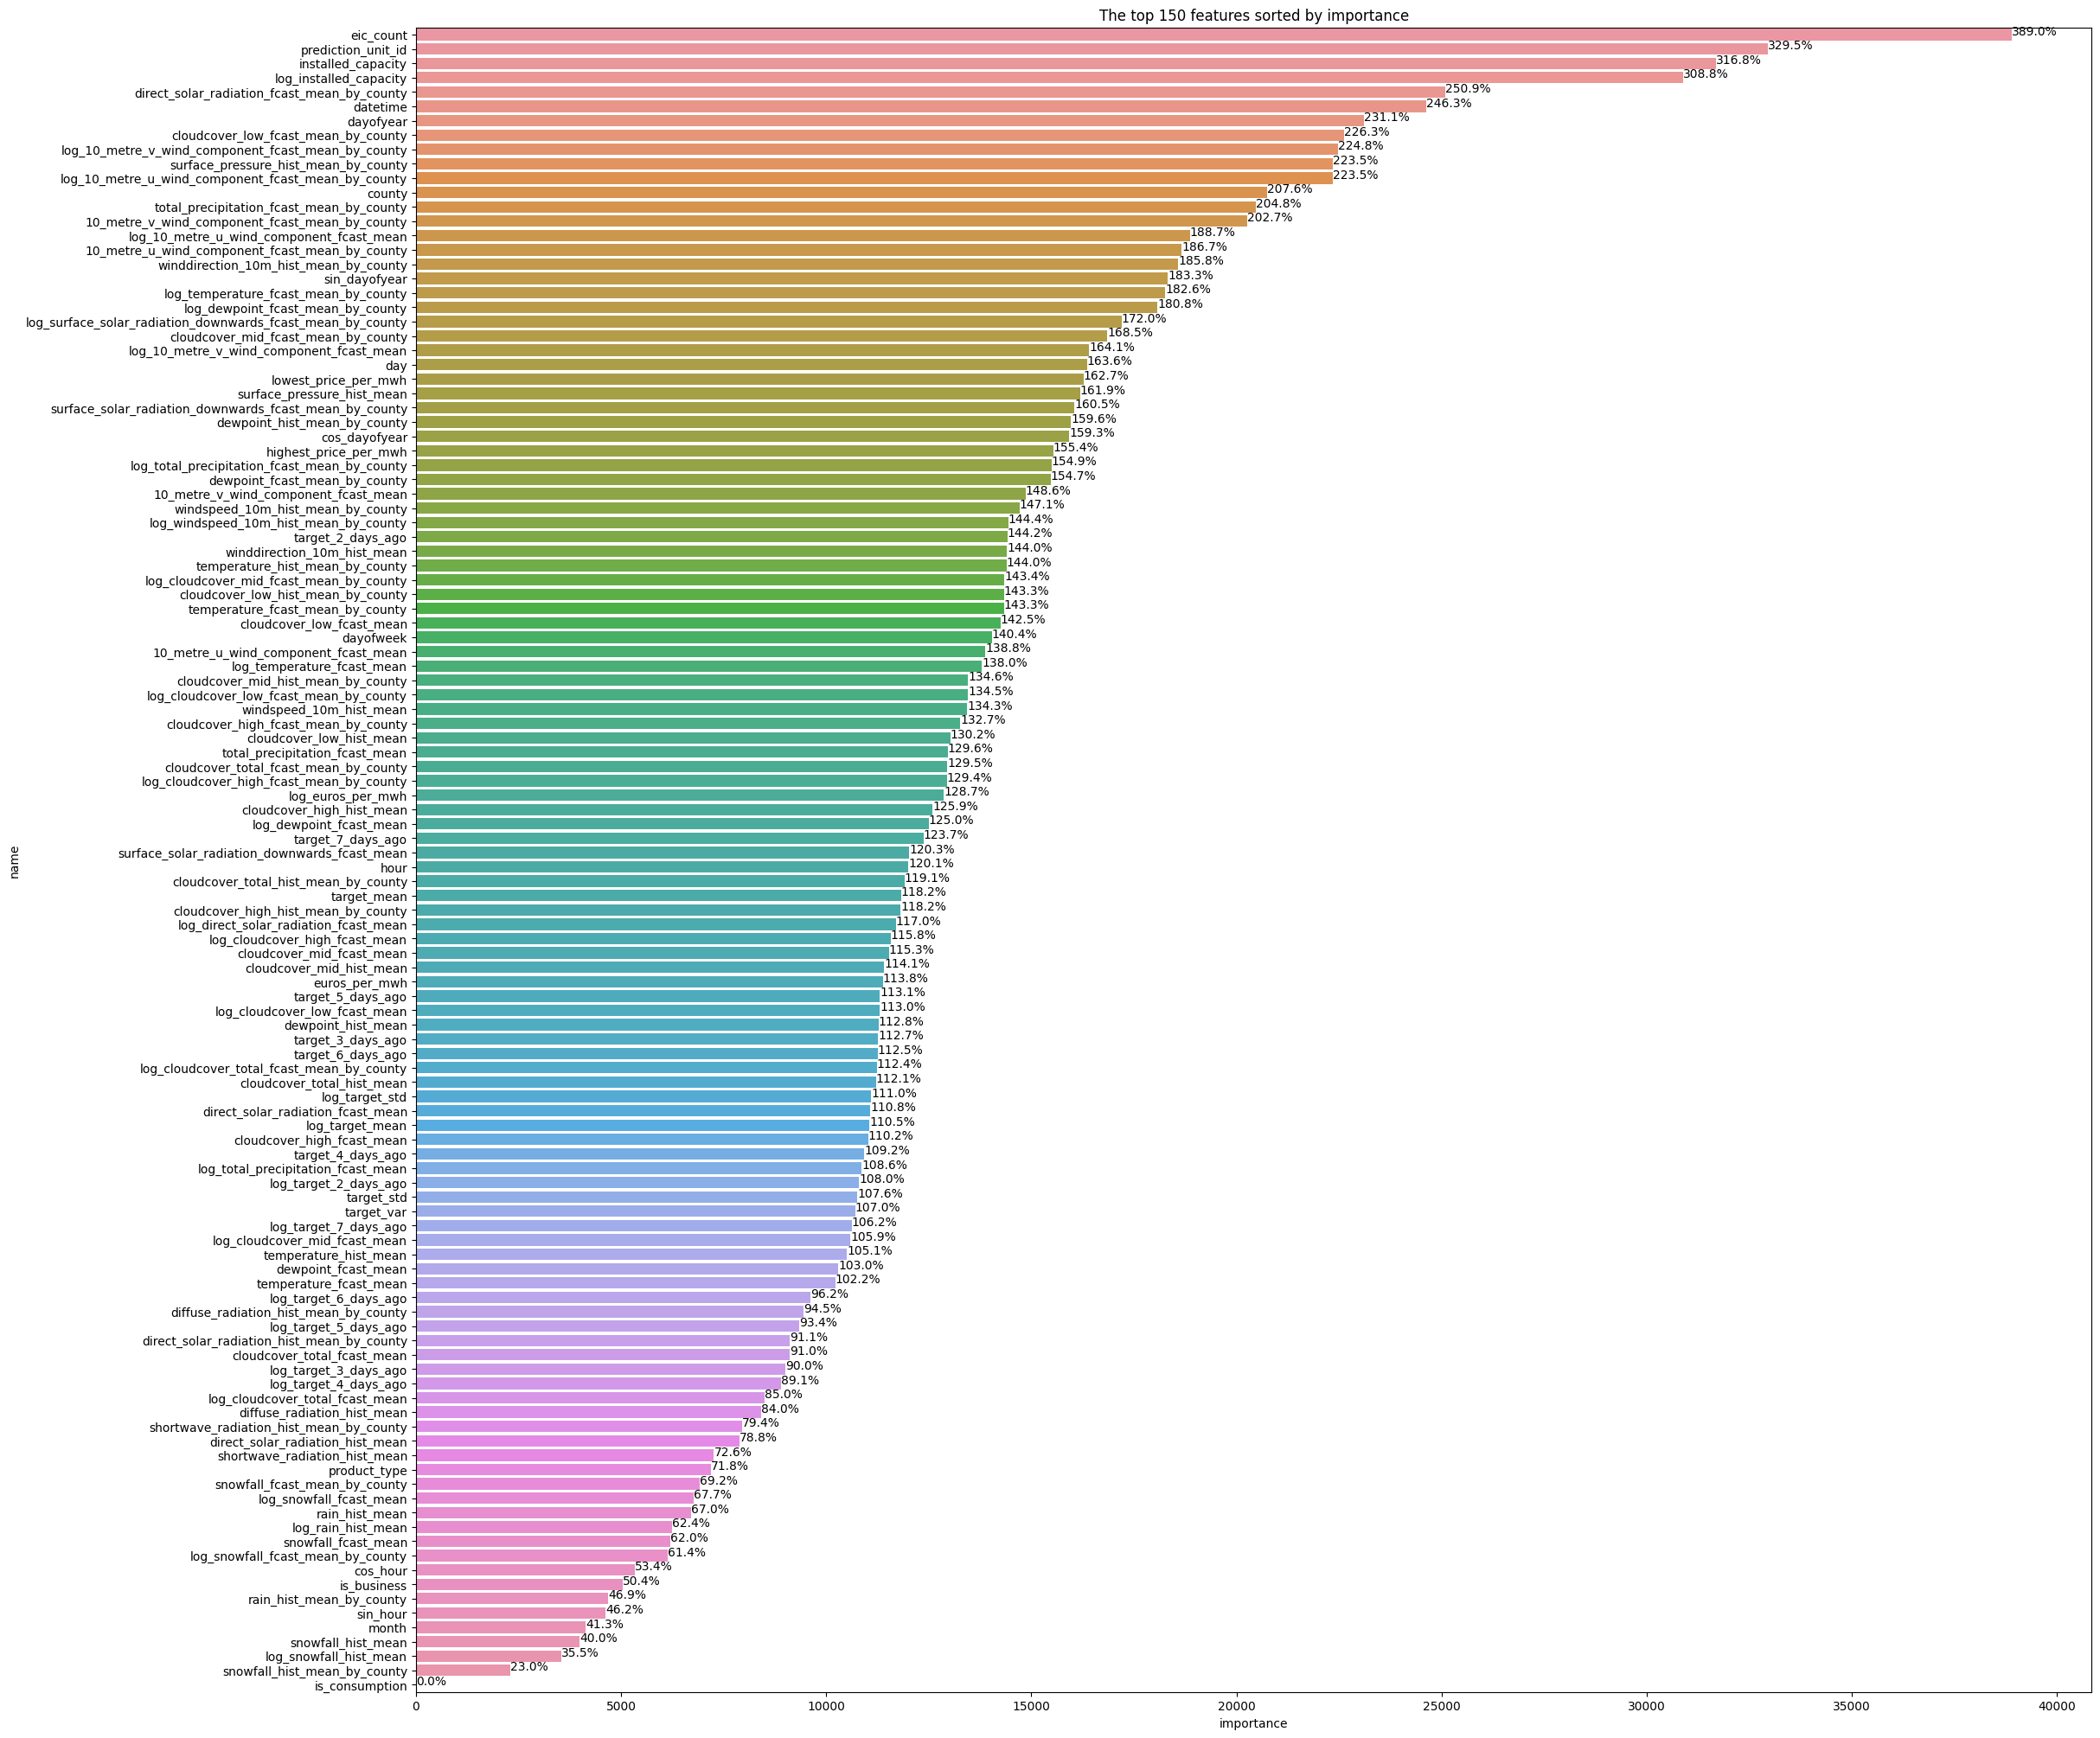

In [13]:
TOP = 150
importance_data = pd.DataFrame({'name': train.drop('target', axis= 1).columns
, 'importance': lgbm2.feature_importances_})
importance_data = importance_data.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(25,25))
sns.barplot(data=importance_data[:TOP],
            x = 'importance',
            y = 'name'
        )
patches = ax.patches
count = 0
for patch in patches:
    height = patch.get_height() 
    width = patch.get_width()
    perc = 0.01*importance_data['importance'].iloc[count]#100*width/len(importance_data)
    ax.text(width, patch.get_y() + height/2, f'{perc:.1f}%')
    count+=1
    
plt.title(f'The top {TOP} features sorted by importance')
plt.show()

## **Test function**

In [14]:
def preTest(data, client, hist_weather, forecast_weather, electricity, gas, locations):
    
    '''Exact same function as the train function but with some tweaks'''
    
    data= data.rename(columns={'prediction_datetime' : 'datetime'})
    data['datetime'] = pd.to_datetime(data['datetime'], utc=True)
    electricity = electricity.rename(columns= {'forecast_date' : 'datetime'})
    electricity['datetime'] = pd.to_datetime(electricity['datetime'], utc= True)
    locations = locations.drop('Unnamed: 0', axis= 1) 
    forecast_weather[['latitude', 'longitude']] = forecast_weather[['latitude', 'longitude']].astype(float).round(1)
    forecast_weather= forecast_weather.merge(locations, how='left', on=['longitude','latitude'])
    forecast_weather.dropna(axis= 0, inplace= True)    
    forecast_weather['county'] = forecast_weather['county'].astype('int64')
    forecast_weather.drop(['origin_datetime', 'latitude', 'longitude', 'hours_ahead', 'data_block_id'], axis=1, inplace= True)
    forecast_weather.rename(columns={'forecast_datetime': 'datetime'}, inplace= True)
    forecast_weather['datetime']= pd.to_datetime(forecast_weather['datetime'], utc= True)
    forecast_weather_datetime= forecast_weather.groupby([forecast_weather['datetime'].
                                            dt.to_period('h')])[list(forecast_weather.drop(['county',
                                                                                            'datetime'], axis= 1)
                                                                     .columns)].mean().reset_index()
    forecast_weather_datetime['datetime']= pd.to_datetime(
        forecast_weather_datetime['datetime'].dt.to_timestamp(), utc=True)
    
    forecast_weather_datetime_county= forecast_weather.groupby(['county',forecast_weather['datetime'].
                              dt.to_period('h')])[list(forecast_weather.drop(['county',
                                                                              'datetime'], axis= 1)
                                                       .columns)].mean().reset_index()
    forecast_weather_datetime_county['datetime']= pd.to_datetime(
        forecast_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)

                
    hist_weather[['latitude', 'longitude']] = hist_weather[['latitude', 'longitude']].astype(float).round(1)

    hist_weather= hist_weather.merge(locations, how='left', on=['longitude','latitude'])    
    
    hist_weather.dropna(axis= 0, inplace= True)
    
    hist_weather.drop(['latitude', 'longitude'], axis=1, inplace= True)

    hist_weather['county'] = hist_weather['county'].astype('int64')
            
    hist_weather['datetime']= pd.to_datetime(hist_weather['datetime'], utc= True)
    
    
    hist_weather_datetime= hist_weather.groupby([hist_weather['datetime'].
                                            dt.to_period('h')])[list(hist_weather.drop(['county',
                                                                                            'datetime', 'data_block_id'], axis= 1)
                                                                     .columns)].mean().reset_index()    
    
    hist_weather_datetime['datetime']= pd.to_datetime(hist_weather_datetime['datetime'].dt.to_timestamp(), utc=True)
    hist_weather_datetime= hist_weather_datetime.merge(hist_weather[['datetime', 'data_block_id']], how='left', on='datetime')
    
    
    hist_weather_datetime_county= hist_weather.groupby(['county',hist_weather['datetime'].
                              dt.to_period('h')])[list(hist_weather.drop(['county',
                                                                              'datetime', 'data_block_id'], axis= 1)
                                                       .columns)].mean().reset_index() 
    hist_weather_datetime_county['datetime']= pd.to_datetime(hist_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)
    hist_weather_datetime_county= hist_weather_datetime_county.merge(hist_weather[['datetime', 'data_block_id']], how='left', on='datetime')
    
    data['year'] = data['datetime'].dt.year
    data['month'] = data['datetime'].dt.month
    data['day'] = data['datetime'].dt.day
    data['hour'] = data['datetime'].dt.hour
    data['dayofweek']= data['datetime'].dt.dayofweek
    data['dayofyear']= data['datetime'].dt.dayofyear

    electricity['hour'] = electricity['datetime'].dt.hour

    
    data= data.merge(client.drop(columns = ['date']), how='left', on=['data_block_id', 'county', 'is_business', 'product_type'])
    data= data.merge(gas[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']], how='left', on='data_block_id')
    data= data.merge(electricity[['euros_per_mwh', 'hour', 'data_block_id']], how='left', on=['hour', 'data_block_id'])
    data= data.merge(forecast_weather_datetime, how='left', on=['datetime'])
    data= data.merge(forecast_weather_datetime_county, how='left', on=['datetime', 'county'],
                     suffixes= ('_fcast_mean','_fcast_mean_by_county'))
    
    hist_weather_datetime['hour']= hist_weather_datetime['datetime'].dt.hour
    hist_weather_datetime_county['hour']= hist_weather_datetime_county['datetime'].dt.hour

    hist_weather_datetime.drop_duplicates(inplace=True)
    hist_weather_datetime_county.drop_duplicates(inplace=True)
    hist_weather_datetime.drop('datetime', axis= 1, inplace= True)
    hist_weather_datetime_county.drop('datetime', axis= 1, inplace= True)

    
    data= data.merge(hist_weather_datetime, how='left', on=['data_block_id', 'hour'])

    data= data.merge(hist_weather_datetime_county, how='left', on=['data_block_id', 'county', 'hour'],
                     suffixes= ('_hist_mean','_hist_mean_by_county'))

    data= data.groupby(['year', 'day', 'hour'], as_index=False).apply(lambda x: x.ffill().bfill()).reset_index()

    data.drop(['level_0', 'level_1', 'row_id', 'data_block_id', 'year'], axis= 1, inplace= True)
    
    return data

In [15]:
def create_revealed_targets_test(data, previous_revealed_targets, N_day_lags):
    '''🎯 Create new test data based on previous_revealed_targets and N_day_lags 🎯 ''' 
    for count, revealed_targets in enumerate(previous_revealed_targets) :
        day_lag = count + 2
        # Get hour
        revealed_targets['hour'] = pd.to_datetime(revealed_targets['datetime'], utc= True).dt.hour
        # Select columns and rename target
        revealed_targets = revealed_targets[['hour', 'prediction_unit_id', 'is_consumption', 'target']]
        revealed_targets = revealed_targets.rename(columns = {"target" : f"target_{day_lag}_days_ago"})
        # Add past revealed targets
        data = pd.merge(data,
                        revealed_targets,
                        how = 'left',
                        on = ['hour', 'prediction_unit_id', 'is_consumption'],
                       )
        
    # If revealed_target_columns not available, replace by nan
    all_revealed_columns = [f"target_{day_lag}_days_ago" for day_lag in range(2, N_day_lags+1)]
    missing_columns = list(set(all_revealed_columns) - set(data.columns))
    data[missing_columns] = np.nan 
    
    return data

## **Submission**

In [16]:
previous_revealed_targets = []
env = enefit.make_env()
iter_test = env.iter_test()
for (test, revealed_targets, client_test, historical_weather_test,
     forecast_weather_test, electricity_test, gas_test,sample_prediction) in iter_test:
    
    # Rename test set to make consistent with train
    test = test.rename(columns = {'prediction_datetime': 'datetime'})
    
    # Initiate column data_block_id with default value to merge the data on
    id_column = 'data_block_id' 
    
    test[id_column] = 0
    gas_test[id_column] = 0
    electricity_test[id_column] = 0
    historical_weather_test[id_column] = 0
    forecast_weather_test[id_column] = 0
    client_test[id_column] = 0
    revealed_targets[id_column] = 0
    
    data_test = preTest(test, client_test, historical_weather_test,
                        forecast_weather_test, electricity_test, gas_test, locations)
    
    data_test['datetime']= pd.to_datetime(data_test['datetime'], utc= True).astype('int64')
    
    # Store revealed_targets
    previous_revealed_targets.insert(0, revealed_targets)
    if len(previous_revealed_targets) == N_day_lags:
        previous_revealed_targets.pop()
    
    # Add previous revealed targets
    df_test = create_revealed_targets_test(data = data_test.copy(),
                                           previous_revealed_targets = previous_revealed_targets.copy(),
                                           N_day_lags = N_day_lags
                                          )
    #Data Transformation
    df_test['sin_hour']= (np.pi * np.sin(df_test['hour']) / 12)
    df_test['cos_hour']= (np.pi * np.cos(df_test['hour']) / 12)
    df_test['sin_hour']= (np.pi * np.sin(df_test['hour']) / 12)
    df_test['cos_hour']= (np.pi * np.cos(df_test['hour']) / 12)
    df_test['sin_dayofyear']= (np.pi * np.sin(df_test['dayofyear']) / 183)
    df_test['cos_dayofyear']= (np.pi * np.cos(df_test['dayofyear']) / 183)
    df_test['target_mean']= df_test[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].mean(1)
    df_test['target_std']= df_test[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].std(1)
    df_test['target_var']= df_test[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].var(1)
    for i in to_log:
        df_test[f"log_{i}"]= np.where((df_test[i])!= 0, np.log(df_test[i]),0)
    X_test = df_test.drop('currently_scored', axis= 1).values

    #Predictions
    test['target'] = lgbm.predict(X_test).clip(0)
    test['target_solar'] = lgbm2.predict(X_test).clip(0)
    test.loc[test['is_consumption']==0, "target"] = test.loc[test['is_consumption']==0, "target_solar"]  
    sample_prediction["target"] = test['target']
    
    #Sending predictions to the API
    env.predict(sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
